# Imports + settings

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
num_of_rois = 7
roi_names = [f"ROI_{i+1}" for i in range(num_of_rois)]
meta_data = pd.read_csv(f'../../data.nosync/phenotypic/subjects_with_meta_{num_of_rois}.csv',
                         index_col= 'Unnamed: 0')
meta_data['Sub ID'] = meta_data['Sub ID'].apply(lambda x: str(x).zfill(7))

# Participant stats

### Take-aways

[WRITE SOME STUFF HERE WHEN THE META DATA IS SORTED OUT]

In [135]:
participants = meta_data.drop_duplicates(subset=['Sub ID', 'Dataset'])
participants['Co-Diagnosis'] = participants['Co-Diagnosis'].replace({np.nan: ''})
participants.groupby(['Diagnosis','Co-Diagnosis', 'Sex']).agg({'Sex':['count'],
                                                                'IQ':['min', 'max', 'mean', 'std'], 
                                                                'Age':['min', 'max', 'mean', 'std']})


Sex     IQ                                \
                              count    min    max        mean        std   
Diagnosis Co-Diagnosis Sex                                                 
ADHD                   Female    18   78.0  128.0  106.937500  13.552214   
                       Male      56   73.0  134.0  107.517857  14.867892   
          Other        Female     8   75.0  127.0  107.375000  15.574131   
                       Male      33   82.0  132.0  103.562500  13.452275   
ASD                    Female     7   78.0  134.0  101.428571  22.618997   
                       Male      50   67.0  137.0  101.740000  17.090169   
          ADHD         Female     3   74.0  132.0  106.666667  29.687259   
                       Male      34   75.0  148.0  110.909091  17.782301   
          Other        Female     3   91.0  118.0  102.333333  14.011900   
                       Male      20   80.0  142.0  110.400000  16.368776   
TD                     Female    71   80.0  140.0  109.179104  14.216854   
                       Male     138   80.0  144.0  113.622222  13.783977   
          Other        Female     1  101.0  101.0  101.000000        NaN   
                       Male       5   81.0  129.0  117.400000  20.427922   

                                  Age                               
                                  min    max       mean        std  
Diagnosis Co-Diagnosis Sex                                          
ADHD                   Female   7.860  17.15  10.785000   2.909496  
                       Male     7.260  17.61  11.393393   2.697494  
          Other        Female   8.610  13.24  10.936250   1.807413  
                       Male     7.240  17.37  11.537576   2.739780  
ASD                    Female   5.220  34.76  14.442857   9.680924  
                       Male     5.320  39.10  12.828120   6.696238  
          ADHD         Female  10.000  38.76  20.174667  16.119519  
                       Male     5.928  26.62  10.593176   5.348535  
          Other        Female   6.750  24.41  17.990000   9.766944  
                       Male     5.920  29.18  13.570500   5.769673  
TD                     Female   5.907  29.13  13.101789   4.888574  
                       Male     5.887  30.78  13.249710   5.438789  
          Other        Female   8.100   8.10   8.100000        NaN  
                       Male     7.190  16.93  12.868000   3.963158

# Plot distribution of voxels

### Take-aways:
When we look at the std/mean ratio, we can see that most of the regions does not vary that much, 1-2%. However the ration for ROI 5, has a ratio of approxmiately 26\%. When investigating ROI 5 along with the age, it is clear that there is some sort of correlation between the size of this ROI and the age. This could be due to the parcelation mask being made for adults?

Looking at the total number of voxels, plottet against age, we see that there is a correlation between age and the number of voxels. Mainly that the younger the subject is, the more voxels there is.

In [110]:
num_of_voxels = pd.read_csv(f'../../data.nosync/stats/num_of_voxels_pr_timestep_{num_of_rois}.csv',
                            index_col= 'Unnamed: 0')
num_of_voxels['Sub ID'] = num_of_voxels['Sub ID'].apply(lambda x: str(x).zfill(7))
num_of_voxels['Total'] = num_of_voxels[roi_names].sum(axis = 1)
num_of_voxels = pd.merge(num_of_voxels, meta_data, how="left", on=['Sub ID', 'Dataset'])

In [111]:
stats_voxels = num_of_voxels[roi_names+['Total']].describe()

In [112]:
stats_voxels = stats_voxels.T.reset_index()
stats_voxels = stats_voxels[['index', 'mean', 'std']]
stats_voxels['ratio'] = stats_voxels['std']/stats_voxels['mean']*100
stats_voxels

,index,mean,std,ratio
0,ROI_1,6140.480573,129.875666,2.115073
1,ROI_2,5664.642127,86.789414,1.532125
2,ROI_3,4317.126789,96.542314,2.236263
3,ROI_4,3999.374233,35.611132,0.890418
4,ROI_5,1662.366053,440.980845,26.527301
5,ROI_6,5430.936605,108.923693,2.005615
6,ROI_7,8334.785276,231.586441,2.778553
7,Total,35549.711656,913.634711,2.570020


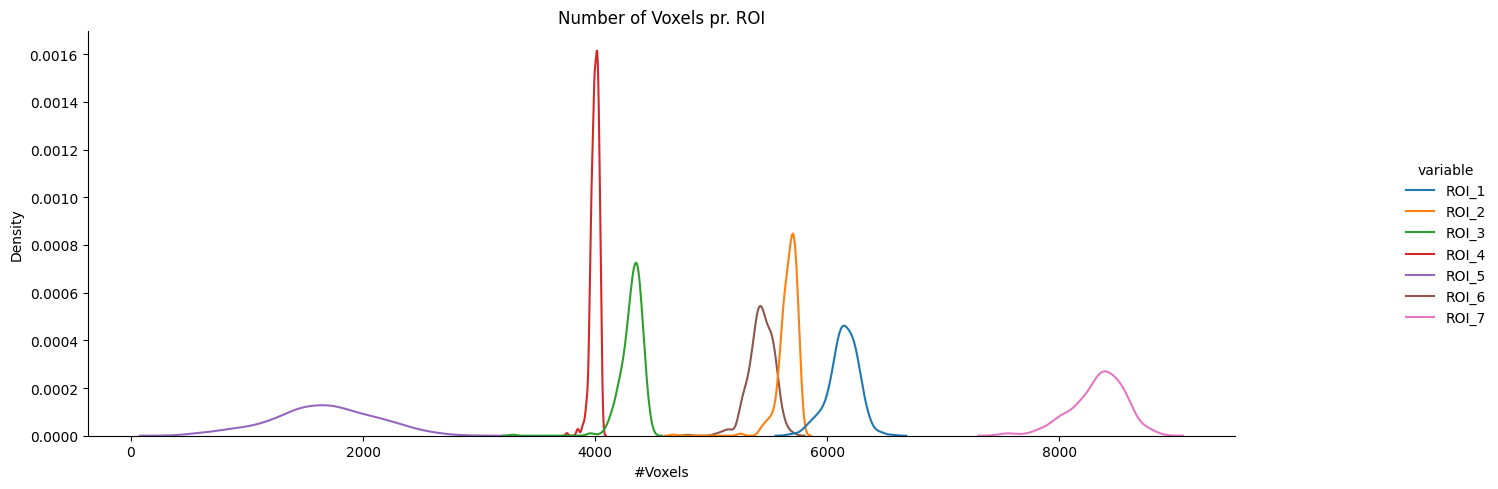

In [113]:
melted = num_of_voxels[roi_names].melt()

# setting the dimensions of the plot
p = sns.displot(data = melted,
            x='value',
            hue='variable',
            kind="kde")
p.set(title='Number of Voxels pr. ROI', xlabel= '#Voxels')
p.fig.set_figwidth(15)
p.fig.set_figheight(5)
p.tight_layout()
p.savefig(f'../pics/{num_of_rois} ROIs/Number_voxels_pr_roi_dist.png', dpi = 300)

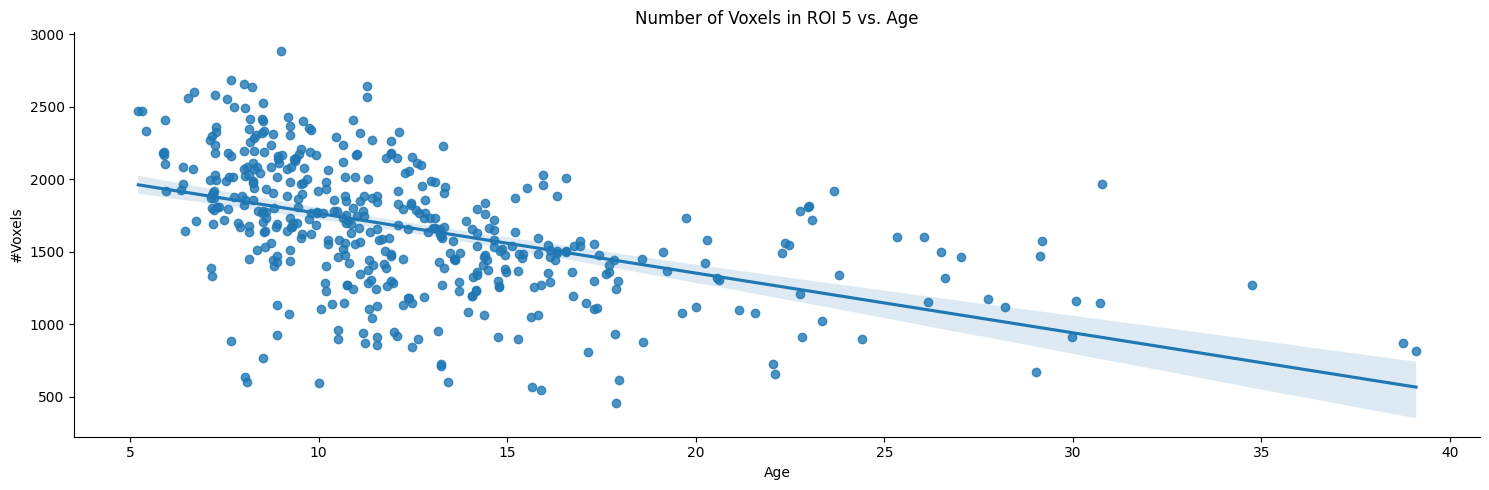

In [114]:
# setting the dimensions of the plot
p = sns.lmplot(data = num_of_voxels,
                    x='Age',
                    y='ROI_5')
p.set(title='Number of Voxels in ROI 5 vs. Age', xlabel= 'Age', ylabel='#Voxels')
p.fig.set_figwidth(15)
p.fig.set_figheight(5)
p.tight_layout()
p.savefig(f'../pics/{num_of_rois} ROIs/ROI5_voxels_age.png', dpi = 300)

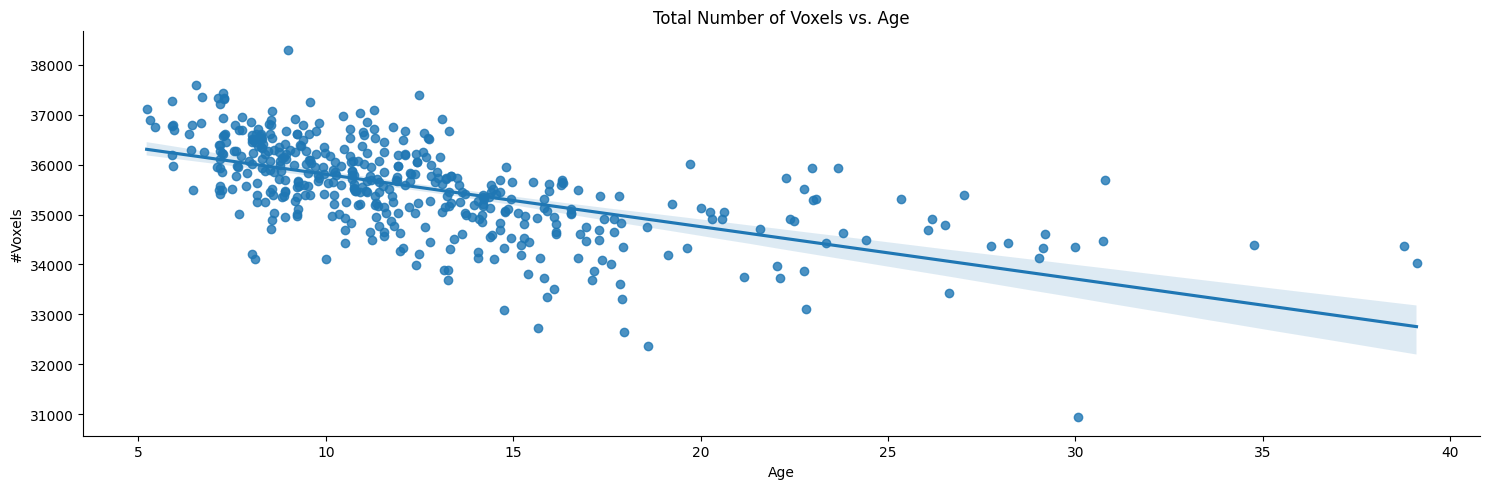

In [115]:
# setting the dimensions of the plot
p = sns.lmplot(data = num_of_voxels,
                    x='Age',
                    y='Total')
p.set(title='Total Number of Voxels vs. Age', xlabel= 'Age', ylabel='#Voxels')
p.fig.set_figwidth(15)
p.fig.set_figheight(5)
p.tight_layout()
p.savefig(f'../pics/{num_of_rois} ROIs/Total_voxels_age.png', dpi = 300)